In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

Getting the data

In [2]:
df = pd.read_csv("https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv")
print(df.shape)
df.head(3)

(5000, 17)


,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2


### Prepairing the dataset

Preparation:

* Make the names lowercase
* Remove the student_id column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution.
* Use the train_test_split function and set the random_state parameter to 1.
* Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.drop('student_id', axis=1, inplace=True)

df.fillna(0, inplace=True)

print(df.shape)
df.head(3)

(5000, 16)


,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,0,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2


In [4]:
y = 'jamb_score'

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train = df_train.loc[:, df.columns != y].copy()
X_val = df_val.loc[:, df.columns != y].copy()
X_test = df_test.loc[:, df.columns != y].copy()

y_train = df_train[y].values
y_val = df_val[y].values
y_test = df_test[y].values

for d in [X_train, X_val, X_test]:
    print(round(len(d)/len(df),2))

0.6
0.2
0.2


### Question 1

Let's train a decision tree regressor to predict the jamb_score variable.

* Train a model with max_depth=1.

Which feature is used for splitting the data?

In [5]:
dv = DictVectorizer(sparse=True)

train_dict = X_train.to_dict(orient='records')
X_train_dv = dv.fit_transform(train_dict)

val_dict = X_val.to_dict(orient='records')
X_val_dv = dv.transform(val_dict)

clf = DecisionTreeRegressor(max_depth=1)
clf = clf.fit(X_train_dv, y_train)
tree_text = export_text(clf, feature_names=list(dv.get_feature_names_out()))
print(tree_text)

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



### Question 2

Train a random forest model with these parameters:

* n_estimators=10
* random_state=1
* n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation

In [6]:
rf = RandomForestRegressor(n_estimators=10, random_state=1,n_jobs=-1)
rf.fit(X_train_dv, y_train)

y_pred = rf.predict(X_val_dv)

rmse = mean_squared_error(y_val, y_pred, squared=False)
round(rmse, 2)

42.14

### Question 3

Now let's experiment with the n_estimators parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set random_state to 1.
* Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

In [7]:
estimators = np.linspace(10, 200, 20, dtype=np.int64)

res = {}
for est in estimators:
    rf = RandomForestRegressor(n_estimators=est, random_state=1,n_jobs=-1)
    rf.fit(X_train_dv, y_train)
    
    y_pred = rf.predict(X_val_dv)
    
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    res[est] = round(rmse, 3)
    

In [8]:
est_res = pd.DataFrame.from_dict(res,orient='index').reset_index()
est_res.columns = ['n_estimators', 'rmse']
est_res

,n_estimators,rmse
0,10,42.137
1,20,41.461
2,30,41.106
3,40,40.917
4,50,40.852
5,60,40.784
6,70,40.677
7,80,40.539
8,90,40.504
9,100,40.517


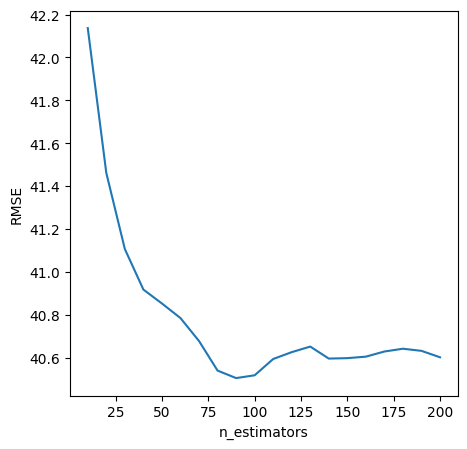

In [9]:
plt.figure(figsize=(5,5))

num_cols = X_train.columns[X_train.dtypes == np.float64]
plt.plot(est_res['n_estimators'], est_res['rmse'])

plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

### Question 4

Let's select the best max_depth:

* Try different values of max_depth: [10, 15, 20, 25]
* For each of these values,
    * try different values of n_estimators from 10 till 200 (with step 10)
    * calculate the mean RMSE
* Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?

In [10]:
estimators = np.linspace(10, 200, 20, dtype=np.int64)
depths = [10, 15, 20, 25]

res_depth = {}
for depth in depths:
    print(f'Processing depth {depth}')
    
    res_est = []
    for est in estimators: 
        rf = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=1,n_jobs=-1)
        rf.fit(X_train_dv, y_train)
        
        y_pred = rf.predict(X_val_dv)
        
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        res_est.append(rmse)

    res_depth[depth] = res_est  

Processing depth 10
Processing depth 15
Processing depth 20
Processing depth 25


In [11]:
for d in res_depth:
    d_mean = round(np.mean(res_depth[d]),3)
    d_std  = round(np.std(res_depth[d]),3)
    print(f'Depth {d}:\tMean {d_mean}\tStd: {d_std}\n')

Depth 10:	Mean 40.392	Std: 0.248

Depth 15:	Mean 40.735	Std: 0.38

Depth 20:	Mean 40.74	Std: 0.368

Depth 25:	Mean 40.788	Std: 0.388



### Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
    * n_estimators=10,
    * max_depth=20,
    * random_state=1,
    * n_jobs=-1 (optional)
* Get the feature importance information from this model

What's the most important feature (among these 4)?

In [12]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1,n_jobs=-1)
rf.fit(X_train_dv, y_train)
feature_names=list(dv.get_feature_names_out())
feature_names[np.argmax(rf.feature_importances_)]

'study_hours_per_week'

### Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

<code>
xgb_params = {
    
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
</code>

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

In [13]:
%%capture output 
# just for supressing output

features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train_dv, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val_dv, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

etas = [0.3, 0.1]
scores = {}

for eta in etas:
    evals_result = {}

    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }
    
    model = xgb.train(xgb_params, dtrain,
                      num_boost_round=100,
                      evals=watchlist,
                      evals_result=evals_result)
    
    key = 'eta=' + str(eta)
    scores[key] = {}
    scores[key]['train_rmse'] = evals_result['train']['rmse']
    scores[key]['val_rmse'] = evals_result['val']['rmse']

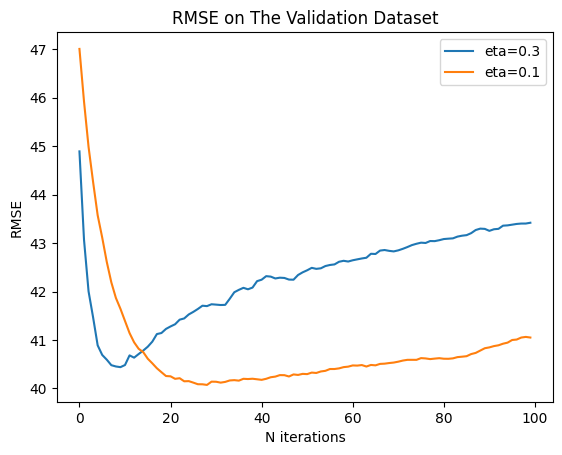

In [14]:
for key in scores:
    df_score = pd.DataFrame.from_dict(scores[key]).reset_index().rename(columns={"index":"num_iter"})
    plt.plot(df_score['num_iter'], df_score['val_rmse'], label=key)

plt.xlabel('N iterations')
plt.ylabel('RMSE')
plt.title('RMSE on The Validation Dataset')
plt.legend()
plt.show()